# Accelerated Backtesting

## Overview
There is a trade-off between the accuracy and speed of backtesting. *hftbacktest* provides highly accurate results, but it is relatively slow, making it challenging to quickly test new ideas or optimize parameters through rapid iteration. To improve backtest speed, this approach excludes certain conditions, sacrificing a certain degree of accuracy.

The main performance gain comes from precomputing fill conditions for a given running interval. This includes ignoring both fills in the queue position and the order response latency, enabling backtesting within a single loop iteration. By removing queue position estimation, we eliminate the need to fully replay the market depth feed or process every depth update.

Thus, this approach accounts for feed latency and order entry latency, but not order-response latency. In the fill simulation, queue position is not modeled, so partial fills do not occur—orders are either fully filled when crossed or not filled at all.

While these simplifications can result in a loss of accuracy—particularly in case that queue position fills are critical typically due to large tick sizes—they offer substantial performance gains.

## Fill Conditions

- A **buy** order is eligible to fill when **order price >= best ask** or **order price > sell trade price**.  
- A **sell** order is eligible to fill when **order price <= best bid** or **order price < buy trade price**.

Because queue position is not considered, equality does not count:

- buy price == sell trade price → **not filled**
- sell price == buy trade price → **not filled**

In short, if the market price crosses the order price (strictly), the order is considered filled.

## Limit Order Fill Prices
For a given time interval [t_i, t_{i+1}]:

**Bid fill price (applies to buy orders):**
```
bid fill price = min(
    lowest best ask at the exchange over the interval,
    (lowest sell trade price + one tick) at the exchange over the interval
)
```
An open buy order with **order price >= bid fill price** is considered filled in the interval.  

**Ask fill price (applies to sell orders):**

```
ask fill price = max(
    highest best bid at the exchange over the interval,
    (highest buy trade price - one tick) at the exchange over the interval
)
```
An open sell order with **order price <= ask fill price** is considered filled in the interval.

## Order Response Latency
To maintain a single state (no separate local and exchange state) and utilize a single-loop iteration, this don't account for order response latency. Consequently, all state changes—order acceptance, cancellation, fills, and position updates—are reflected immediately on the local side.

## Preprocessed Data Structure

```
                          row[t]                                             row[t+1]
Local
+-------------------------------------------------------------+----------------------------
|local_ts[t]                                                  |local_ts[t+1]
|                                                             |
|best_bid[t]                                                  |best_bid[t+1]
|best_ask[t]                                                  |best_ask[t+1]
+-------------------------------------------------------------+---------------------------
Exchange
+-------------------------------------------------------------+---------------------------
|                                                bid_fill[t+1]|
|                                                ask_fill[t+1]|
+----------------------------+--------------------------------+---------------------------
|  order entry latency at    |order_ack_ts[t]                 |
|                local_ts[t] |                                |
|                            |best_bid_ack[t]                 |
|                            |best_ask_ack[t]                 |
|                            |                                |
|             bid_fill_ack[t]|           bid_fill_after_ack[t]|
|             ask_fill_ack[t]|           ask_fill_after_ack[t]|
+----------------------------+--------------------------------+---------------------------
```

The open order which is already acknowledged by the exchange between local_ts[t] to local_ts[t + 1] is filled by bid_fill[t + 1] or ask_fill[t + 1] based on the fill condition we describe above and the local knows it at local_ts[t + 1].

If a user sends a new order at local_ts[t], this order is checked if accepted based on best_bid_ack[t] or best_ask_ack[t] (if it is GTX, or marketable order). And if the limit order is accepted, it is checked if is filled until local_ts[t + 1] by bid_fill_after_ack[t] or ask_fill_after_ack[t]. A user know it at local_ts[t + 1].

If a user sends a cancel order at local_ts[t], the open order is checked if it is filled before cancel request is acknowledge by bid_fill_ack[t] or ask_fill_ack[t]. And also a user know it at local_ts[t + 1].

If order entry latency is high enough that the order request arrives at exchange after local_ts[t + 1], compose the row as shown in the following. 

```
Local
+------------------------------+-------------------------------------------------------------+-------------
|local_ts[t]                   |local_ts[t+1]                                                |local_ts[t+2]
|                              |                                                             |
|best_bid[t]                   |best_bid[t+1]                                                |
|best_ask[t]                   |best_ask[t+1]                                                |
+------------------------------+-------------------------------------------------------------+-------------
Exchange
+------------------------------+-------------------------------------------------------------+-------------
|                 bid_fill[t+1]|                                                bid_fill[t+2]|
|                 ask_fill[t+1]|                                                ask_fill[t+2]|
+------------------------------+------------------------+------------------------------------+-------------
|           order entry latency at local_ts[t]          |order_ack_ts[t]                     |
|                                                       |                                    |
|                                                       |best_bid_ack[t]                     |
|                                                       |best_ask_ack[t]                     |
|                                                       |                                    |
|                                        bid_fill_ack[t]|               bid_fill_after_ack[t]|
|                                        ask_fill_ack[t]|               ask_fill_after_ack[t]|
+------------------------------+------------------------+---+--------------------------------+-------------
|                              |                            |order_ack_ts[t+1]               |
|                              |                            |                                |
|                              |                            |best_bid_ack[t+1]               |
|                              |                            |best_ask_ack[t+1]               |
+------------------------------+----------------------------+--------------------------------+-------------
|                              | order entry latency at     |order_ack_ts[t+1]               |
|                              |              local_ts[t+1] |                                |
|                              |                            |best_bid_ack[t+1]               |
|                              |                            |best_ask_ack[t+1]               |
|                              |                            |                                |
|                              |           bid_fill_ack[t+1]|         bid_fill_after_ack[t+1]|
|                              |           ask_fill_ack[t+1]|         ask_fill_after_ack[t+1]|
+------------------------------+----------------------------+--------------------------------+-------------
```

## Preprocessing Market Data for Accelerated Backtesting

In [1]:
import numpy as np
import numba as nb
from numba import njit
from numba.experimental import jitclass

INVALID_MIN = 0
INVALID_MAX = np.iinfo(np.int64).max - 1

In [2]:
@jitclass
class Clock:
    timestamp: nb.int64[:]
    rn: nb.int64
    ts: nb.int64
    
    def __init__(self, timestamp, rn):
        self.timestamp = timestamp
        self.rn = rn
        if self.rn >= len(self.timestamp):
            self.ts = INVALID_MAX
        else:
            self.ts = self.timestamp[self.rn]

    def next(self):
        if self.rn == len(self.timestamp) - 1:
            self.ts = INVALID_MAX
        else:
            self.rn += 1
            self.ts = self.timestamp[self.rn]

@njit
def select_event(timestamps):
    # Finds the earliest timestamped event to process first.
    earliest_ts = INVALID_MAX
    ev = -1
    for i in range(len(timestamps)):
        if timestamps[i] < earliest_ts:
            earliest_ts = timestamps[i]
            ev = i
    return ev

In [3]:
order_latency_dtype = np.dtype([('req_ts', 'i8'), ('exch_ts', 'i8'), ('resp_ts', 'i8'), ('_padding', 'i8')])

@jitclass
class IntpOrderLatency:
    rn: nb.int64
    data: nb.from_dtype(order_latency_dtype)[:]
    
    def __init__(self, data):
        self.rn = 0
        self.data = data
        
    def entry(self, timestamp):
        # Returns the order entry latency, interpolated from the order entry latency before the timestamp 
        # and the order entry latency after the timestamp.
        while (
            self.rn < len(self.data)
            and self.data[self.rn].req_ts < timestamp
        ):
            self.rn += 1

        if self.rn == 0:
            entry_latency = self.data[self.rn].exch_ts - self.data[self.rn].req_ts
        elif self.rn == len(self.data):
            entry_latency = self.data[self.rn - 1].exch_ts - self.data[self.rn - 1].req_ts
        else:
            # todo: Handle negative latency values, which indicate a technical issue 
            #       (e.g., server overload) that causes the order request to be rejected.
            #       Please see https://docs.rs/hftbacktest/latest/hftbacktest/backtest/models/struct.IntpOrderLatency.html
            prev_req_ts = self.data[self.rn - 1].req_ts
            next_req_ts = self.data[self.rn].req_ts
            prev_entry_latency = self.data[self.rn - 1].exch_ts - prev_req_ts
            next_entry_latency = self.data[self.rn].exch_ts - next_req_ts
            
            entry_latency = np.divide(
                next_entry_latency - prev_entry_latency, 
                next_req_ts - prev_req_ts
            ) * (timestamp - prev_req_ts) + prev_entry_latency

        return entry_latency

In [4]:
@njit
def ack_order(
    tick_size,
    order_ack_ts,
    next_local_ts,
    book_ticker_rn,
    book_ticker_exch_ts,
    book_ticker,
    trades_rn,
    trades_exch_ts,
    trades
):
    # This function finds the fill prices around order_ack_ts, as well as the best bid and best ask at order_ack_ts.
    # - Fill prices between local_ts[t] and order_ack_ts[t]
    # - Fill prices between order_ack_ts[t] and local_ts[t + n], where local_ts[t + n] > order_ack_ts[t]
    
    # Initializes the values from the last best bid and best ask.
    best_bid_tick = round(book_ticker[book_ticker_rn - 1].bid_px / tick_size)
    ask_fill_tick = ask_fill_tick_ack = best_bid_tick_ack = high_best_bid_tick = best_bid_tick
    best_ask_tick = round(book_ticker[book_ticker_rn - 1].ask_px / tick_size)
    bid_fill_tick = bid_fill_tick_ack = best_ask_tick_ack = low_best_ask_tick = best_ask_tick
    
    high_buy_tick = INVALID_MIN
    low_sell_tick = INVALID_MAX

    book_ticker_exch_clock = Clock(book_ticker_exch_ts, book_ticker_rn)
    trades_exch_clock = Clock(trades_exch_ts, trades_rn)
    
    while True:
        ev = select_event(np.asarray([
            book_ticker_exch_clock.ts,
            trades_exch_clock.ts,
            order_ack_ts,
            next_local_ts
        ]))

        if ev == -1:
            raise ValueError
        elif ev == 0:
            best_bid_tick = round(book_ticker[book_ticker_exch_clock.rn].bid_px / tick_size)
            best_ask_tick = round(book_ticker[book_ticker_exch_clock.rn].ask_px / tick_size)

            if best_bid_tick > high_best_bid_tick:
                high_best_bid_tick = best_bid_tick
            if best_ask_tick < low_best_ask_tick:
                low_best_ask_tick = best_ask_tick
                
            book_ticker_exch_clock.next()
        elif ev == 1:
            side = trades[trades_exch_clock.rn].side
            px_tick = round(trades[trades_exch_clock.rn].px / tick_size)
            
            if side == 1 and px_tick > high_buy_tick:
                high_buy_tick = px_tick
            elif side == -1 and px_tick < low_sell_tick:
                low_sell_tick = px_tick

            trades_exch_clock.next()
        elif ev == 2:
            # An order request is acknowledged by the exchange at order_ack_ts[t].
            bid_fill_tick_ack = min(low_sell_tick + 1, low_best_ask_tick)
            ask_fill_tick_ack = max(high_buy_tick - 1, high_best_bid_tick)
            best_bid_tick_ack = best_bid_tick
            best_ask_tick_ack = best_ask_tick

            high_buy_tick = INVALID_MIN
            high_best_bid_tick = best_bid_tick
            low_sell_tick = INVALID_MAX
            low_best_ask_tick = best_ask_tick
            
            order_ack_ts = INVALID_MAX
        elif ev == 3:
            # at local_ts[t + n] > order_ack_ts[t]
            bid_fill_tick = min(low_sell_tick + 1, low_best_ask_tick)
            ask_fill_tick = max(high_buy_tick - 1, high_best_bid_tick)
            break
            
    return (
        bid_fill_tick_ack,
        ask_fill_tick_ack,
        best_bid_tick_ack,
        best_ask_tick_ack,
        bid_fill_tick,
        ask_fill_tick
    )

In [5]:
@njit
def preprocess_data(
    tick_size,
    end_ts,
    local_ts,
    book_ticker_exch_ts,
    book_ticker_local_ts,
    book_ticker,
    trades_exch_ts,
    trades,
    order_latency
):
    # Preprocessed data
    # All prices are in ticks to avoid additional operations to prevent floating-point comparison errors.
    out_t = 0
    out_size = len(local_ts)
    # timestamp at local := local_ts[t]
    out_local_ts = np.empty(out_size, np.int64)
    # best bid at local at local_ts[t]
    out_best_bid_tick = np.empty(out_size, np.int64)
    # best ask at local at local_ts[t]
    out_best_ask_tick = np.empty(out_size, np.int64)
    # bid fill price in ticks for the interval local_ts[t - 1] ~ local_ts[t]
    # any open buy orders during this interval with a price greater than or equal to this price are considered filled.
    out_bid_fill_tick = np.empty(out_size, np.int64)
    # ask fill price in ticks for the interval local_ts[t - 1] ~ local_ts[t]
    # any open sell orders during this interval with a price less than or equal to this price are considered filled.
    out_ask_fill_tick = np.empty(out_size, np.int64)
    # order acknowledgment timestamp at the exchange, when an order is sent at local_ts[t], is defined as order_ack_ts[t].
    out_order_ack_ts = np.empty(out_size, np.int64)
    # bid fill price in ticks for the interval local_ts[t] ~ order_ack_ts[t]
    # any open buy orders during this interval with a price greater than or equal to this price are considered filled.
    out_bid_fill_tick_ack = np.empty(out_size, np.int64)
    # ask fill price in ticks for the interval local_ts[t] ~ order_ack_ts[t]
    # any open sell orders during this interval with a price less than or equal to this price are considered filled.
    out_ask_fill_tick_ack = np.empty(out_size, np.int64)
    # best bid at the exchange at order_ack_ts[t]
    # used to determine whether the order should be accepted (limit or market) or rejected (GTX).
    out_best_bid_tick_ack = np.empty(out_size, np.int64)
    # best ask at the exchange at order_ack_ts[t]
    # used to determine whether the order should be accepted (limit or market) or rejected (GTX).
    out_best_ask_tick_ack = np.empty(out_size, np.int64)
    # bid fill price in ticks for the interval order_ack_ts[t] ~ local_ts[t + n] where local_ts[t + n] > order_ack_ts[t].
    # any open buy orders during this interval with a price greater than or equal to this price are considered filled.
    out_bid_fill_tick_after_ack = np.empty(out_size, np.int64)
    # ask fill price in ticks for the interval order_ack_ts[t] ~ local_ts[t + n] where local_ts[t + n] > order_ack_ts[t].
    # any open sell orders during this interval with a price less than or equal to this price are considered filled.
    out_ask_fill_tick_after_ack = np.empty(out_size, np.int64)
    
    local_best_bid_tick = exch_best_bid_tick = INVALID_MIN
    local_best_ask_tick = exch_best_ask_tick = INVALID_MAX
    high_buy_tick = high_best_bid_tick = INVALID_MIN
    low_sell_tick = low_best_ask_tick = INVALID_MAX

    # Initializes the clocks
    # todo: For better accuracy, it also needs to combine the best bid and ask from Level-2 market depth data
    #       with the best bid and ask from the book ticker.
    book_ticker_exch_clock = Clock(book_ticker_exch_ts, 0)
    book_ticker_local_clock = Clock(book_ticker_local_ts, 0)
    trades_exch_clock = Clock(trades_exch_ts, 0)
    local_clock = Clock(local_ts, 0)

    order_latency_rn = 0

    while local_clock.ts <= end_ts:
        # Selects the event to process.
        ev = select_event(np.asarray([
            book_ticker_exch_clock.ts,
            book_ticker_local_clock.ts,
            trades_exch_clock.ts,
            local_clock.ts
        ]))

        if ev == -1:
            # Should not happen.
            raise ValueError
        elif ev == 0:
            # Updates the current exchange best bid and best ask.
            exch_best_bid_tick = round(book_ticker[book_ticker_exch_clock.rn].bid_px / tick_size)
            exch_best_ask_tick = round(book_ticker[book_ticker_exch_clock.rn].ask_px / tick_size)

            # Updates the highest and lowest best bid and best ask at the exchange.
            if exch_best_bid_tick > high_best_bid_tick:
                high_best_bid_tick = exch_best_bid_tick
            if exch_best_ask_tick < low_best_ask_tick:
                low_best_ask_tick = exch_best_ask_tick

            book_ticker_exch_clock.next()
        elif ev == 1:
            # Updates the current local best bid and best ask.
            local_best_bid_tick = round(book_ticker[book_ticker_local_clock.rn].bid_px / tick_size)
            local_best_ask_tick = round(book_ticker[book_ticker_local_clock.rn].ask_px / tick_size)
    
            book_ticker_local_clock.next()
        elif ev == 2:
            side = trades[trades_exch_clock.rn].side
            px_tick = round(trades[trades_exch_clock.rn].px / tick_size)

            # Updates the highest and lowest trade at the exchange.
            if side == 1 and px_tick > high_buy_tick:
                high_buy_tick = px_tick
            elif side == -1 and px_tick < low_sell_tick:
                low_sell_tick = px_tick

            trades_exch_clock.next()
        elif ev == 3:
            # Records the fill prices in ticks at the exchange between local_ts[t - 1] and local_ts[t].
            out_bid_fill_tick[out_t] = min(low_sell_tick + 1, low_best_ask_tick)
            out_ask_fill_tick[out_t] = max(high_buy_tick - 1, high_best_bid_tick)

            high_buy_tick = INVALID_MIN
            high_best_bid_tick = exch_best_bid_tick
            low_sell_tick = INVALID_MAX
            low_best_ask_tick = exch_best_ask_tick
            
            # Records the current local state at local_ts[t].
            out_local_ts[out_t] = local_clock.ts
            out_best_bid_tick[out_t] = local_best_bid_tick
            out_best_ask_tick[out_t] = local_best_ask_tick

            # Order acknowledgement timestamp when the exchange receives the order request.
            order_entry_latency = order_latency.entry(local_clock.ts)
            order_ack_ts = local_clock.ts + order_entry_latency
            
            # The next local timestamp after the exchange acknowledges the order request.
            next_local_clock = Clock(local_ts, local_clock.rn)
            while next_local_clock.ts < order_ack_ts:
                next_local_clock.next()
            next_local_ts = next_local_clock.ts

            # Computes the fill prices around the order acknowledgment timestamp at the exchange
            # and finds the best bid and best ask at the time of acknowledgment.
            (
                bid_fill_tick_ack,
                ask_fill_tick_ack,
                best_bid_tick_ack,
                best_ask_tick_ack,
                bid_fill_tick,
                ask_fill_tick
            ) = ack_order(
                tick_size,
                order_ack_ts,
                next_local_ts,
                book_ticker_exch_clock.rn + 1,
                book_ticker_exch_ts,
                book_ticker,
                trades_exch_clock.rn + 1,
                trades_exch_ts,
                trades
            )
                
            # Records the values related to the order acknowledgment.
            out_order_ack_ts[out_t] = order_ack_ts
            out_bid_fill_tick_ack[out_t] = bid_fill_tick_ack
            out_ask_fill_tick_ack[out_t] = ask_fill_tick_ack
            out_best_bid_tick_ack[out_t] = best_bid_tick_ack
            out_best_ask_tick_ack[out_t] = best_ask_tick_ack
            out_bid_fill_tick_after_ack[out_t] = bid_fill_tick
            out_ask_fill_tick_after_ack[out_t] = ask_fill_tick
        
            out_t += 1

            local_clock.next()
            
    return (
        out_local_ts[:out_t],
        out_best_bid_tick[:out_t],
        out_best_ask_tick[:out_t],
        out_bid_fill_tick[:out_t],
        out_ask_fill_tick[:out_t],
        out_order_ack_ts[:out_t],
        out_bid_fill_tick_ack[:out_t],
        out_ask_fill_tick_ack[:out_t],
        out_best_bid_tick_ack[:out_t],
        out_best_ask_tick_ack[:out_t],
        out_bid_fill_tick_after_ack[:out_t],
        out_ask_fill_tick_after_ack[:out_t]
    )

## Preprocessing Example

Tardis.dev provides free sample data for the first day of each month.

In [6]:
# !curl -o BTCUSDT_incremental_book_L2_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/incremental_book_L2/2025/08/01/BTCUSDT.csv.gz
# !curl -o BTCUSDT_trades_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/trades/2025/08/01/BTCUSDT.csv.gz
# !curl -o BTCUSDT_book_ticker_20250801.csv.gz https://datasets.tardis.dev/v1/binance-futures/book_ticker/2025/08/01/BTCUSDT.csv.gz

In [7]:
import polars as pl

def load_book_ticker(file):
    df = pl.read_csv(file)
    exch_ts = df['timestamp'].to_numpy() * 1000
    local_ts = df['local_timestamp'].to_numpy() * 1000
    data = df.select(
        pl.col('ask_amount').alias('ask_qty'),
        pl.col('ask_price').alias('ask_px'),
        pl.col('bid_price').alias('bid_px'),
        pl.col('bid_amount').alias('bid_qty'),
    ).to_numpy(structured=True)
    return exch_ts, local_ts, data

def load_trades(file):
    df = pl.read_csv(file)
    exch_ts = df['timestamp'].to_numpy() * 1000
    local_ts = df['local_timestamp'].to_numpy() * 1000
    data = df.select(
        pl.when(pl.col('side') == 'buy').then(1).otherwise(-1).alias('side'),
        pl.col('price').alias('px'),
        pl.col('amount').alias('qty'),
    ).to_numpy(structured=True)
    return exch_ts, local_ts, data


In [8]:
# For demonstration purposes, order latency artificially derived from feed latency is used.
# For more realistic backtesting, actual order latency data should be used.
# Please see https://hftbacktest.readthedocs.io/en/latest/tutorials/Order%20Latency%20Data.html

from hftbacktest.data.utils.tardis import convert_fuse
from hftbacktest.data.utils import feed_order_latency

# First, we convert the Tardis data into the normalized format to use the utility 
# that generates order latency from feed latency.
# This normalized data will also be used to compare accelerated backtesting 
# (which removes certain conditions) against full backtesting (which includes all conditions).
convert_fuse(
    'BTCUSDT_trades_20250801.csv.gz', 
    'BTCUSDT_incremental_book_L2_20250801.csv.gz',
    'BTCUSDT_book_ticker_20250801.csv.gz',
    tick_size=0.1,
    lot_size=0.001,
    output_filename='BTCUSDT_20250801.npz'
)

# Generates order latency from feed latency.
# At any given time:
#   - Order entry latency = 4 × feed latency
#   - Order response latency = 3 × feed latency
# Please see the document for details about the arguments.
feed_order_latency.generate_order_latency(
    'BTCUSDT_20250801.npz',
    output_file='feed_order_latency_20250801.npz',
    mul_entry=4,
    mul_resp=3
)

order_latency_data = np.load('feed_order_latency_20250801.npz')['data']
order_latency = IntpOrderLatency(order_latency_data)

Correcting the latency
Correcting the event order
Saving to BTCUSDT_20250801.npz


In [9]:
tick_size = 0.1
lot_size = 0.001

In [10]:
import datetime

# 0.1 seconds
running_interval = 100_000_000
start_ts = int(datetime.datetime(2025, 8, 1, tzinfo=datetime.timezone.utc).timestamp() * 1_000_000_000) + running_interval
end_ts = int(datetime.datetime(2025, 8, 2, tzinfo=datetime.timezone.utc).timestamp() * 1_000_000_000)

# In the final interval, to compute fill prices after order acknowledgment,
# a small buffer beyond `end_ts` is necessary.
local_ts = np.arange(start_ts, end_ts + 100 * running_interval, running_interval)

# Additionally, the following day’s data should be concatenated to compute accurate fill prices for the final interval.
def concat(a, b):
    ret = []
    for aa, bb in zip(a, b):
        ret.append(np.concatenate([aa, bb], axis=0))
    return ret
    
# book_ticker = concat(
#     load_book_ticker('BTCUSDT_book_ticker_20250501.csv.gz'),
#     load_book_ticker('BTCUSDT_book_ticker_20250502.csv.gz')
# )
# trades = concat(
#     load_trades('BTCUSDT_trades_20250501.csv.gz'),
#     load_trades('BTCUSDT_trades_20250502.csv.gz')
# )

# For demonstration purposes, a single day of data is used.
book_ticker = load_book_ticker('BTCUSDT_book_ticker_20250801.csv.gz')
trades = load_trades('BTCUSDT_trades_20250801.csv.gz')

In [11]:
%%time

out = preprocess_data(
    tick_size,
    end_ts,
    local_ts,
    book_ticker[0],
    book_ticker[1],
    book_ticker[2],
    trades[0],
    trades[2],
    order_latency
)

CPU times: user 9.12 s, sys: 81.2 ms, total: 9.2 s
Wall time: 9.17 s


In [12]:
import pyarrow as pa
import pyarrow.parquet as pq

# Saves the preprocessed data to a Parquet file.
table = pa.table({
    'local_ts': out[0],
    'best_bid_tick': out[1],
    'best_ask_tick': out[2],
    'bid_fill_tick': out[3],
    'ask_fill_tick': out[4],
    'order_ack_ts': out[5],
    'bid_fill_tick_ack': out[6],
    'ask_fill_tick_ack': out[7],
    'best_bid_tick_ack': out[8],
    'best_ask_tick_ack': out[9],
    'bid_fill_tick_after_ack': out[10],
    'ask_fill_tick_after_ack': out[11]
})

pq.write_table(table, 'BTCUSDT_20250801.parquet', compression='zstd')

## Accelerated Backtesting Using Preprocessed Market Data

In [13]:
from hftbacktest.types import record_dtype

@njit
def accelerated_backtest(
    relative_half_spread,
    skew,
    order_notional_value,
    max_notional_position,
    fee,
    tick_size,
    lot_size,
    local_ts,
    best_bid_tick,
    best_ask_tick,
    bid_fill_tick,
    ask_fill_tick,
    order_ack_ts,
    bid_fill_tick_ack,
    ask_fill_tick_ack,
    best_bid_tick_ack,
    best_ask_tick_ack,
    bid_fill_tick_after_ack,
    ask_fill_tick_after_ack
):
    # req_bid_tick: bid order price in ticks (limit buy order with GTX) sent to the exchange, before the exchange acknowledges it.
    # req_ask_tick: ask order price in ticks (limit sell order with GTX) sent to the exchange, before the exchange acknowledges it.
    # open_bid_tick: bid order price in ticks acknowledged by the exchange, currently an open order in the market.
    # open_ask_tick: ask order price in ticks acknowledged by the exchange, currently an open order in the market.
    #
    # INVALID_MIN and INVALID_MAX indicate that there are no orders.
    #
    # Example:
    #   If req_bid_tick is INVALID_MIN and there is an open bid order, 
    #   the open bid order will be canceled (if the cancel request reaches the exchange before the order is filled).
    #   When an order is filled, its price is set to INVALID_MIN or INVALID_MAX accordingly.
    req_bid_tick = open_bid_tick = INVALID_MIN
    req_ask_tick = open_ask_tick = INVALID_MAX
    # corresponding order quantities.
    open_bid_qty = req_bid_qty = 0.0
    open_ask_qty = req_ask_qty = 0.0

    # Initial state.
    balance = 0.0
    position = 0.0
    num_trades = 0
    trading_value = 0.0
    trading_volume = 0.0

    # Row index iterator
    t = 0

    # State record for stats
    rec_i = 0
    record = np.empty(len(local_ts), record_dtype)
    
    while True:
        #--------------------------------------------------------
        # Local bot logic at `local_ts[t]`.
        mid_tick = (best_bid_tick[t] + best_ask_tick[t]) / 2.0
        mid_px = mid_tick * tick_size
        
        notional_position_value = position * mid_px
        normalized_position = notional_position_value / max_notional_position

        relative_bid_depth = relative_half_spread + skew * normalized_position
        relative_ask_depth = relative_half_spread - skew * normalized_position

        req_bid_tick = min(np.floor(mid_tick * (1.0 - relative_bid_depth)), best_bid_tick[t])
        req_ask_tick = max(np.ceil(mid_tick * (1.0 + relative_ask_depth)), best_ask_tick[t])

        req_bid_qty = req_ask_qty = max(round(order_notional_value / mid_px / lot_size) * lot_size, lot_size)
        
        # If the position exceeds the risk limit (max notional position),
        # no orders shall be open in that direction.
        if normalized_position > 1:
            req_bid_tick = INVALID_MIN
        if normalized_position < -1:
            req_ask_tick = INVALID_MAX

        #--------------------------------------------------------
        # Records the current state.
        record[rec_i].timestamp = local_ts[t]
        record[rec_i].price = mid_tick * tick_size
        record[rec_i].position = position
        record[rec_i].balance = balance * tick_size
        record[rec_i].fee = trading_value * tick_size * fee
        record[rec_i].num_trades = num_trades
        record[rec_i].trading_volume = trading_volume
        record[rec_i].trading_value = trading_value * tick_size
        
        rec_i += 1

        #--------------------------------------------------------
        # Processes the exchange-side logic (order fill logic).
        
        # If any of the requested order prices differ from the open order's price,
        # it is assumed that the bot sent the order request.
        # The request will be acknowledged and processed at `order_ack_ts[t]`.
        # Otherwise, check if the open order is filled.
        if req_bid_tick != open_bid_tick or req_ask_tick != open_ask_tick:
            # The current time is `order_ack_ts[t]`.
            order_ack_ts_ = order_ack_ts[t]

            # If there are open orders with valid prices,
            # checks whether they are filled before accepting the newly requested orders.
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick_ack[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick_ack[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX
            
            # New orders are treated as GTX. 
            # If the requested buy order price is greater than or equal to the best ask,
            # or the requested sell order price is less than or equal to the best bid, 
            # the orders are rejected.
            # Invalidates the price if the order is rejected.
            if req_bid_tick >= best_ask_tick_ack[t]:
                req_bid_tick = INVALID_MIN
            if req_ask_tick <= best_bid_tick_ack[t]:
                req_ask_tick = INVALID_MAX

            # Updates the open orders to reflect accepted orders.
            open_bid_tick = req_bid_tick
            open_ask_tick = req_ask_tick
            open_bid_qty = req_bid_qty
            open_ask_qty = req_ask_qty

            # If there are open orders with valid prices,
            # checks whether they are filled before the next local timestamp (`local_ts[t+n]`)
            # that is greater than the current timestamp (`order_ack_ts[t]`).
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick_after_ack[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick_after_ack[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX

            # The next local timestamp must be greater than the current timestamp (`order_ack_ts[t]`).
            while t < len(local_ts) and local_ts[t] < order_ack_ts_:
                t += 1
            # Breaks if no more rows remain for processing.
            if t == len(local_ts):
                break
        else:
            # Checks if the open orders are filled between two local timestamps.
            # The next row of data contains the bid fill price (in ticks) and ask fill price (in ticks) 
            # for that interval (step).
            t += 1
            # Breaks if no more rows remain for processing.
            if t == len(local_ts):
                break

            # # If there are open orders with valid prices, checks if they are filled.
            if open_bid_tick > INVALID_MIN and open_bid_tick >= bid_fill_tick[t]:
                execute_value = open_bid_tick * open_bid_qty
                balance -= execute_value
                position += open_bid_qty
                num_trades += 1
                trading_volume += open_bid_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_bid_tick = INVALID_MIN
            if open_ask_tick < INVALID_MAX and open_ask_tick <= ask_fill_tick[t]:
                execute_value = open_ask_tick * open_ask_qty
                balance += execute_value
                position -= open_ask_qty
                num_trades += 1
                trading_volume += open_ask_qty
                trading_value += execute_value
                # Invalidates the price because the order is filled.
                open_ask_tick = INVALID_MAX
        
    return record[:rec_i]

In [14]:
%%time

table = pq.read_table('BTCUSDT_20250801.parquet')

local_ts = table['local_ts'].to_numpy()
best_bid_tick = table['best_bid_tick'].to_numpy()
best_ask_tick = table['best_ask_tick'].to_numpy()
bid_fill_tick = table['bid_fill_tick'].to_numpy()
ask_fill_tick = table['ask_fill_tick'].to_numpy()
order_ack_ts = table['order_ack_ts'].to_numpy()
bid_fill_tick_ack = table['bid_fill_tick_ack'].to_numpy()
ask_fill_tick_ack = table['ask_fill_tick_ack'].to_numpy()
best_bid_tick_ack = table['best_bid_tick_ack'].to_numpy()
best_ask_tick_ack = table['best_ask_tick_ack'].to_numpy()
bid_fill_tick_after_ack = table['bid_fill_tick_after_ack'].to_numpy()
ask_fill_tick_after_ack = table['ask_fill_tick_after_ack'].to_numpy()

relative_half_spread = 0.00025
skew = relative_half_spread
order_notional_value = 50000
max_notional_position = order_notional_value * 20
fee_per_value = -0.00005 # 0.5% rebates

record = accelerated_backtest(
        relative_half_spread,
        skew,
        order_notional_value,
        max_notional_position,
        fee_per_value,
        tick_size,
        lot_size,
        local_ts,
        best_bid_tick,
        best_ask_tick,
        bid_fill_tick,
        ask_fill_tick,
        order_ack_ts,
        bid_fill_tick_ack,
        ask_fill_tick_ack,
        best_bid_tick_ack,
        best_ask_tick_ack,
        bid_fill_tick_after_ack,
        ask_fill_tick_after_ack
)

CPU times: user 318 ms, sys: 85.3 ms, total: 404 ms
Wall time: 310 ms


In [15]:
from hftbacktest.stats import LinearAssetRecord

stats = (
    LinearAssetRecord(record)
        .resample('1s')
        .stats(book_size=max_notional_position)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-02 00:00:00,7.60934,10.894142,0.001196,0.003273,350.0,17.49908,0.365565,0.000068,347732.5629


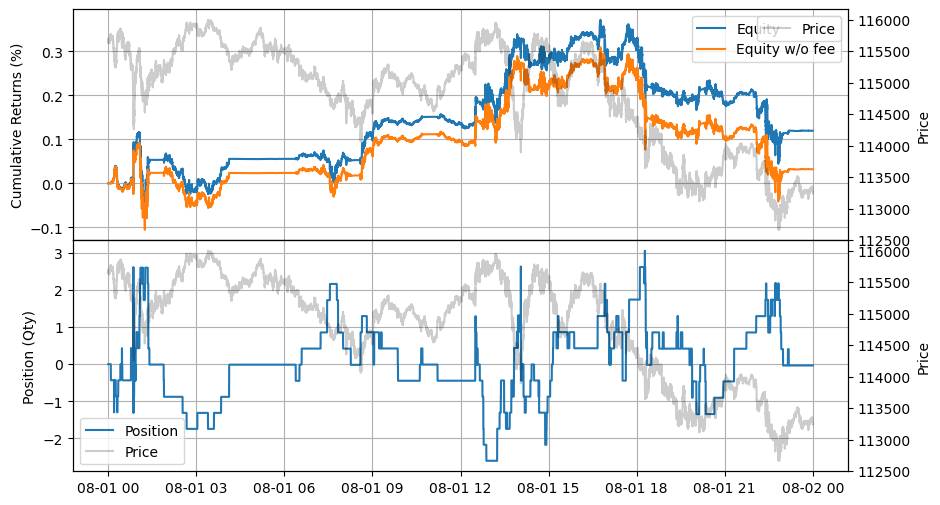

In [16]:
stats.plot()

## Comparison of Backtesting Results with Full Backtesting

In [17]:
from numba import uint64
from numba.typed import Dict
from hftbacktest import (
    GTX,
    LIMIT,
    BUY,
    SELL,
    Recorder,
    BacktestAsset,
    ROIVectorMarketDepthBacktest
)
from hftbacktest.stats import LinearAssetRecord

@njit
def basic_mm(
    hbt,
    stat,
    relative_half_spread,
    skew,
    interval,
    order_notional_value,
    max_notional_position,
    grid_num,
    grid_interval_tick
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)

        skip = False
        orders = hbt.orders(asset_no)
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            if not order.cancellable:
                skip = True
                break
        if skip:
            continue
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        
        mid_tick = (depth.best_bid_tick + depth.best_ask_tick) / 2.0
        mid_px = mid_tick * tick_size

        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        notional_position_value = position * mid_px
        normalized_position = notional_position_value / max_notional_position

        relative_bid_depth = relative_half_spread + skew * normalized_position
        relative_ask_depth = relative_half_spread - skew * normalized_position

        bid_price_tick = min(np.floor(mid_tick * (1.0 - relative_bid_depth)), depth.best_bid_tick)
        ask_price_tick = max(np.ceil(mid_tick * (1.0 + relative_ask_depth)), depth.best_ask_tick)

        order_qty = max(round(order_notional_value / mid_px / lot_size) * lot_size, lot_size)
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if normalized_position < 1:
            for i in range(grid_num):
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price_tick * tick_size
                
                bid_price_tick -= grid_interval_tick

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if normalized_position > -1:
            for i in range(grid_num):
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price_tick * tick_size

                ask_price_tick += grid_interval_tick
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [18]:
%%time

roi_lb = 50000
roi_ub = 150000

grid_num = 1
grid_interval_tick = 1

asset = (
    BacktestAsset()
        .data(['BTCUSDT_20250801.npz'])
        .linear_asset(1.0) 
        .intp_order_latency(['feed_order_latency_20250801.npz'])
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

basic_mm(
    hbt,
    recorder.recorder,
    relative_half_spread,
    skew,
    running_interval,
    order_notional_value,
    max_notional_position,
    grid_num,
    grid_interval_tick
)

_ = hbt.close()

CPU times: user 1min 45s, sys: 3.73 s, total: 1min 49s
Wall time: 1min 49s


In [19]:
data = recorder.get(0)
stats = (
    LinearAssetRecord(data)
        .resample('1s')
        .stats(book_size=max_notional_position)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-08-01 00:00:00,2025-08-01 23:59:59,7.033126,10.104532,0.00119,0.00299,348.004028,17.399667,0.397857,0.000068,349253.6362


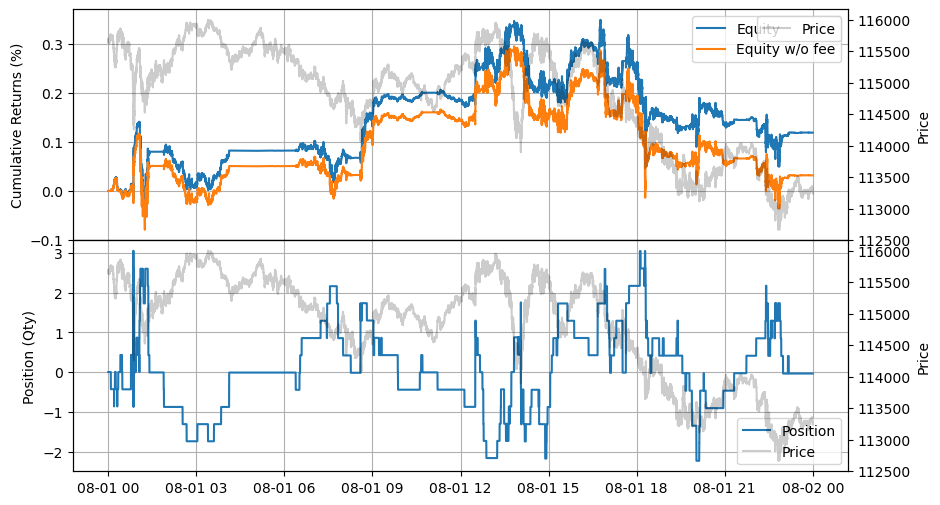

In [20]:
stats.plot()

Firstly, accelerated backtest: 416 ms; full backtest: 1 min 49 s — roughly 260× faster.

You can see that there are differences in the detailed numbers, but overall, the results show similar characteristics in terms of position and equity. The differences can become larger depending on the strategy’s characteristics—especially, as mentioned earlier, for assets where fills in the queue is crucial, such as those with a large tick size. Therefore, it is still important to verify the results from accelerated backtesting against those from full backtesting.

## Precompute Signal - Order Book Imbalance

Similarly, precomputing the signal speeds up backtesting and allows rapid iteration to test ideas and tune parameters.

In [21]:
@njit
def depth_below(depth, start, end, roi_lb_tick):
    for i in range(start, end - 1, -1):
        if depth[i - roi_lb_tick] > 0:
            return i
    return INVALID_MIN


@njit
def depth_above(depth, start, end, roi_lb_tick):
    for i in range(start, end + 1):
        if depth[i - roi_lb_tick] > 0:
            return i
    return INVALID_MAX

@njit
def precompute_obi(
    tick_size,
    lot_size,
    roi_lb,
    roi_ub,
    end_ts,
    local_ts, 
    depth_local_ts,
    depth,
    depth_range
):
    roi_lb_tick = round(roi_lb / tick_size)
    roi_ub_tick = round(roi_ub / tick_size)
    bid_depth = np.zeros(roi_ub_tick - roi_lb_tick, np.float64)
    ask_depth = np.zeros(roi_ub_tick - roi_lb_tick, np.float64)

    best_bid_tick = INVALID_MIN
    best_ask_tick = INVALID_MAX
    low_bid_tick = INVALID_MAX
    high_ask_tick = INVALID_MIN
    
    depth_local_clock = Clock(depth_local_ts, 0)
    local_clock = Clock(local_ts, 0)

    out_t = 0
    out_mid_tick = np.empty(len(local_ts), np.float64)
    out_bid_qty = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_bid_weighted = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_ask_qty = np.empty((len(local_ts), len(depth_range)), np.float64)
    out_ask_weighted = np.empty((len(local_ts), len(depth_range)), np.float64)
    
    while local_clock.ts <= end_ts:
        ev = select_event(np.asarray([
            depth_local_clock.ts,
            local_clock.ts
        ]))

        if ev == -1:
            raise ValueError
        elif ev == 0:
            # Builds the market depth.
            side = depth[depth_local_clock.rn].side
            px_tick = round(depth[depth_local_clock.rn].px / tick_size)

            # Skips processing if the depth update price falls outside the defined range of interest.
            if px_tick > roi_ub_tick or px_tick < roi_lb_tick:
                depth_local_clock.next()
                continue
            
            qty = depth[depth_local_clock.rn].qty
            qty_lot = round(qty / lot_size)
            
            if side == 1:
                bid_depth[px_tick - roi_lb_tick] = qty
                if px_tick < low_bid_tick:
                    low_bid_tick = px_tick
                if px_tick > best_bid_tick and qty_lot > 0:
                    # Updates the best bid if the bid price is higher than the current best bid.
                    best_bid_tick = px_tick
                    if best_bid_tick >= best_ask_tick:
                        # When the best bid is greater than or equal to the best ask,
                        # updates the best ask to the lowest ask above the new best bid.
                        best_ask_tick = depth_above(ask_depth, best_bid_tick + 1, high_ask_tick, roi_lb_tick)
                elif px_tick == best_bid_tick and qty_lot == 0:
                    # Finds the new best bid if the current best bid is deleted.
                    best_bid_tick = depth_below(bid_depth, px_tick, low_bid_tick, roi_lb_tick)
            else:
                ask_depth[px_tick - roi_lb_tick] = qty
                if px_tick > high_ask_tick:
                    high_ask_tick = px_tick
                if px_tick < best_ask_tick and qty_lot > 0:
                    # Updates the best ask if the ask price is lower than the current best ask.
                    best_ask_tick = px_tick
                    if best_ask_tick <= best_bid_tick:
                        # When the best ask is less than or equal to the best bid,
                        # updates the best bid to the highest bid below the new best ask.
                        best_bid_tick = depth_below(bid_depth, best_ask_tick - 1, low_bid_tick, roi_lb_tick)
                elif px_tick == best_ask_tick and qty_lot == 0:
                    # Finds the best ask if the current best ask is deleted.
                    best_ask_tick = depth_above(ask_depth, px_tick, high_ask_tick, roi_lb_tick)

            depth_local_clock.next()
        elif ev == 1:
            if best_bid_tick == INVALID_MIN or best_ask_tick == INVALID_MAX:
                mid_tick = np.nan
                out_bid_qty[out_t, :] = np.nan
                out_bid_weighted[out_t, :] = np.nan
                out_ask_qty[out_t, :] = np.nan
                out_ask_weighted[out_t, :] = np.nan
            else:
                mid_tick = (best_bid_tick + best_ask_tick) / 2
    
                # Computes the order book imbalance for the depth range from the mid-price.
                # Please see https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html
                #
                # To compute order-book imbalance values, aggregate over depth levels d, where d
                # denotes the tick distance from the mid price; d is symmetric from the mid tick.
                #   mid_tick, Sum{Q_bid[d]},  Sum{Q_ask[d]},  Sum{d * Q_bid[d]},  Sum{d * Q_ask[d]}
                #
                # VAMP = (Sum{P_bid[d] * Q_ask[d]} + Sum{P_ask[d] * Q_bid[d]}) / (Sum{Q_bid[d]} + Sum{Q_ask[d]})
                #      = tick_size * (mid_tick * Sum{Q_ask[d]} - Sum{d * Q_ask[d]} + mid_tick * Sum{Q_bid[d]} + Sum{d * Q_bid[d]})
                #        / (Sum{Q_bid[d]} + Sum{Q_ask[d]})
                #
                # Bid_effective = Sum{P_bid[d] * Q_bid[d]} / Sum{Q_bid[d]}
                #               = tick_size * (mid_tick * Sum{Q_bid[d]} - Sum{d * Q_bid[d]}) / Sum{Q_bid[d]}
                # Ask_effective = Sum{P_ask[d] * Q_ask[d]} / Sum{Q_ask[d]}
                #               = tick_size * (mid_tick * Sum{Q_ask[d]} + Sum{d * Q_ask[d]}) / Sum{Q_ask[d]}
                i = 0
                bid_qty = 0.0
                bid_weighted = 0.0
                for d in range(best_bid_tick, low_bid_tick - 1, -1):
                    bid_qty += bid_depth[d - roi_lb_tick]
                    bid_weighted += bid_depth[d - roi_lb_tick] * (mid_tick - d)
    
                    if d < mid_tick * (1 - depth_range[i]):
                        out_bid_qty[out_t, i] = bid_qty
                        out_bid_weighted[out_t, i] = bid_weighted
                        i += 1
                        if i == len(depth_range):
                            break
    
                i = 0
                ask_qty = 0.0
                ask_weighted = 0.0
                for d in range(best_ask_tick, high_ask_tick + 1):
                    ask_qty += ask_depth[d - roi_lb_tick]
                    ask_weighted += ask_depth[d - roi_lb_tick] * (d - mid_tick)
                    
                    if d > mid_tick * (1 + depth_range[i]):
                        out_ask_qty[out_t, i] = ask_qty
                        out_ask_weighted[out_t, i] = ask_weighted
                        i += 1
                        if i == len(depth_range):
                            break

            out_mid_tick[out_t] = mid_tick
    
            out_t += 1
            
            local_clock.next()
    return out_mid_tick[:out_t], out_bid_qty[:out_t], out_bid_weighted[:out_t], out_ask_qty[:out_t], out_ask_weighted[:out_t]

In [22]:
def load_incremental_book(file):
    df = pl.read_csv(file)
    exch_ts = df['timestamp'].to_numpy() * 1000
    local_ts = df['local_timestamp'].to_numpy() * 1000
    data = df.select(
        pl.col('is_snapshot').cast(pl.Int32),
        pl.when(pl.col('side') == 'bid').then(1).otherwise(-1).alias('side'),
        pl.col('price').alias('px'),
        pl.col('amount').alias('qty'),
    ).to_numpy(structured=True)
    return exch_ts, local_ts, data

# Because the BTCUSDT market depth data is very large, converting it using Polars often crashes due to memory limits.
# Parsing directly in Python is slower but uses less memory.
import gzip

def load_incremental_book(file, buffer_size=200_000_000):
    depth_dtype = np.dtype([
        ('is_snapshot', np.int32),
        ('side', np.int32),
        ('px', np.float64),
        ('qty', np.float64)
    ])
    
    exch_ts = np.empty(buffer_size, np.int64)
    local_ts = np.empty(buffer_size, np.int64)
    data = np.empty(buffer_size, depth_dtype)
    with gzip.open(file) as f:
        header = True
        i = 0
        while True:
            line = f.readline()
            if not line:
                break
            if header:
                header = False
                continue
            columns = line.decode().split(',')
            if i == buffer_size:
                raise MemoryError('Not enough buffer size to load data')
            exch_ts[i] = int(columns[2]) * 1000
            local_ts[i] = int(columns[3]) * 1000
            data[i][0] = 1 if columns[4] == 'true' else 0
            data[i][1] = 1 if columns[5] == 'bid' else -1
            data[i][2] = float(columns[6])
            data[i][3] = float(columns[7])
            i += 1
    return exch_ts[:i], local_ts[:i], data[:i]

In [23]:
depth = load_incremental_book('BTCUSDT_incremental_book_L2_20250801.csv.gz')

local_ts = np.arange(start_ts, end_ts + running_interval, running_interval)

In [24]:
roi_lb = 50000
roi_ub = 150000

depth_range = np.asarray([0.0025, 0.005, 0.0075, 0.01, 0.015, 0.02, 0.025, 0.03])

(
    out_mid_tick,
    out_bid_qty,
    out_bid_weighted,
    out_ask_qty,
    out_ask_weighted
) = precompute_obi(
    tick_size,
    lot_size,
    roi_lb,
    roi_ub,
    end_ts,
    local_ts, 
    depth[1],
    depth[2],
    depth_range
)

table_def = {
    'local_ts': local_ts,
    'mid_tick': out_mid_tick
}
for i, d in enumerate(depth_range):
    table_def[f'bid_qty_{d}'] = out_bid_qty[:, i]
    table_def[f'bid_weighted_{d}'] = out_bid_weighted[:, i]
    table_def[f'ask_qty_{d}'] = out_ask_qty[:, i]
    table_def[f'ask_weighted_{d}'] = out_ask_weighted[:, i]

pq.write_table(pa.table(table_def), f'BTCUSDT_obi_20250801.parquet', compression='zstd')

In [25]:
table = pq.read_table('BTCUSDT_obi_20250801.parquet')
local_ts = table['local_ts'].to_numpy()
mid_tick = table['mid_tick'].to_numpy()

# VAMP = (Sum{P_bid[d] * Q_ask[d]} + Sum{P_ask[d] * Q_bid[d]}) / (Sum{Q_bid[d]} + Sum(Q_ask[d])}
# Sum{P_bid[d] * Q_ask[d]} + Sum{P_ask[d] * Q_bid[d]} 
# = tick_size * (mid_tick * Sum{Q_ask[d]} - Sum{d * Q_ask[d]} + mid_tick * Sum{Q_bid[d]} + Sum{d * Q_bid[d]})
#
# P_effective_bid = Sum{P_bid[d] * Q_bid[d]} / Sum{Q_bid[d]}
# Sum{P_bid[d] * Q_bid[d]}
# = tick_size * (mid_tick * Sum{Q_bid[d]} - Sum{d * Q_bid[d]})

depth_range = 0.01

bid_qty = table[f'bid_qty_{depth_range}'].to_numpy()
ask_qty = table[f'ask_qty_{depth_range}'].to_numpy()
bid_weighted = table[f'bid_weighted_{depth_range}'].to_numpy()
ask_weighted = table[f'ask_weighted_{depth_range}'].to_numpy()

vamp = np.divide(
    tick_size * (
        mid_tick * ask_qty - ask_weighted
        + mid_tick * bid_qty + bid_weighted
    ),
    bid_qty + ask_qty
)

bid_eff = tick_size * (mid_tick * bid_qty - bid_weighted) / bid_qty
ask_eff = tick_size * (mid_tick * ask_qty + ask_weighted) / ask_qty
vamp_eff = np.divide(
    bid_eff * ask_qty + ask_eff * bid_qty,
    bid_qty + ask_qty
)

/tmp/ipykernel_55790/3891548179.py:20: RuntimeWarning: invalid value encountered in divide
  vamp = np.divide(
/tmp/ipykernel_55790/3891548179.py:28: RuntimeWarning: invalid value encountered in divide
  bid_eff = tick_size * (mid_tick * bid_qty - bid_weighted) / bid_qty
/tmp/ipykernel_55790/3891548179.py:29: RuntimeWarning: invalid value encountered in divide
  ask_eff = tick_size * (mid_tick * ask_qty + ask_weighted) / ask_qty


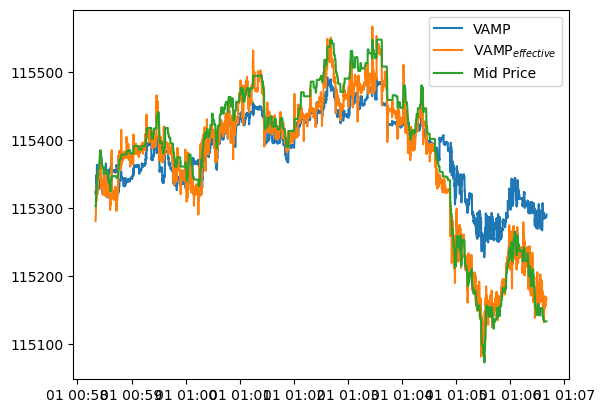

In [26]:
from matplotlib import pyplot as plt

start = 35000
end = 40000

ts = pl.Series("timestamp", local_ts)
ts_dt = ts.cast(pl.Datetime('ns'))

plt.plot(ts_dt[start:end], vamp[start:end])
plt.plot(ts_dt[start:end], vamp_eff[start:end])
plt.plot(ts_dt[start:end], mid_tick[start:end] * tick_size)
plt.legend(['VAMP', 'VAMP$_{effective}$', 'Mid Price'])

to be continued...